# Depression Detector

Detecting depression in Twitter Tweets

In [1]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [2]:
# pip install ftfy

In [3]:
# pip install --upgrade pip

In [4]:
pip install -U gensim

Requirement already up-to-date: gensim in c:\users\manasi\anaconda3\lib\site-packages (4.1.2)
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install word2vec

Note: you may need to restart the kernel to use updated packages.


In [6]:
import matplotlib.pyplot as plt
# from wordcloud import WordCloud
#from textblob import TextBlob
from math import log, sqrt, exp
import pandas as pd
import numpy as np
from numpy import sign

import re
import warnings
warnings.filterwarnings("ignore")
import ftfy
#from bs4 import BeautifulSoup

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

from keras import optimizers
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import gensim
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MANASI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# Reproducibility
np.random.seed(1234)

DEPRES_NROWS = 15000  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 10000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 280 # Max tweet size
MAX_NB_WORDS = 25000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.5
EPOCHS= 20

In [8]:
DEPRESSIVE_TWEETS_CSV = 'vader_processed_final.csv'
RANDOM_TWEETS_CSV = 'Sentiment Analysis Dataset 2.csv'
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'

In [9]:
#RANDOM_TWEETS_CSV.head()

In [10]:
#pd.read_csv('vader_processed_final.csv')

In [11]:
depressive_tweets_df = pd.read_csv(DEPRESSIVE_TWEETS_CSV, usecols = range(1,5), nrows = DEPRES_NROWS)
random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV, encoding = "ISO-8859-1", usecols = range(0,4), nrows = RANDOM_NROWS)

In [12]:
random_tweets_df.head()

,ï»¿ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [13]:
depressive_tweets_df.head()

,Unnamed: 0.1,vader_sentiment_label,vader_score,clean_tweet
0,0,0,-0.4122,"Wow, dad yday: “you don’t take stupid depressi..."
1,1,0,-0.8074,part really harmfult lot people went every gui...
2,2,1,0.3382,one ways I got #depression learning dance rain...
3,3,0,-0.4588,"see wanna one say PTSD, depression, and/or anx..."
4,4,0,-0.8316,IS IT clinical depression palpable hopelessnes...


# Preprocessing

Expand contractions, remove links, hashtags, capitalization, and punctuation, deal with negation. Remove links and urls along with whitespaces and stop words. Additionally, stop words beyond the standard NLTK stop words must to be removed to make the model more robust, including days of the week and months.

In [14]:
emojies = [":‑)", ":)", ":D", ":o)", ":]", ":3", ":c)", ":>", "=]", "8)", "=)", ":}", ":^)", ":っ)", ":‑D", "8‑D", "8D", "x‑D", "xD", "X‑D", "XD", "=‑D", "=D", "=‑3", "=3", "B^D", ":-))", ">:[", ":‑(", ":(", ":‑c", ":c", ":‑<", ":っC", ":<", ":‑[", ":[", ":{", ";(", ":-||", ":@", ">:(", ":'‑(", ":'(", ":'‑)", ":')", "D:<", "D:", "D8", "D;", "D=", "DX", "v.v", "D‑':", ">:O", ":‑O", ":O", ":‑o", ":o", "8‑0", "O_O", "o‑o", "O_o", "o_O", "o_o", "O-O", ":*", ":-*", ":^*", "(", "}{'", ")", ";‑)", ";)", "*-)", "*)", ";‑]", ";]", ";D", ";^)", ":‑,", ">:P", ":‑P", ":P", "X‑P", "x‑p", "xp", "XP", ":‑p", ":p", "=p", ":‑Þ", ":Þ", ":þ", ":‑þ", ":‑b", ":b", "d:", ">:\\", ">:/", ":‑/", ":‑.", ":/", ":\\", "=/", "=\\", ":L", "=L", ":S", ">.<", ":|", ":‑|", ":$", ":‑X", ":X", ":‑#", ":#", "O:‑)", "0:‑3", "0:3", "0:‑)", "0:)", "0;^)", ">:)", ">;)", ">:‑)", "}:‑)", "}:)", "3:‑)", "3:)", "o/\o", "^5", ">_>^", "^<_<", "|;‑)", "|‑O", ":‑J", ":‑&", ":&", "#‑)", "%‑)", "%)", ":‑###..", ":###..", "<:‑|", "<*)))‑{", "><(((*>", "><>", "\o/", "*\0/*", "@}‑;‑'‑‑‑", "@>‑‑>‑‑", "~(_8^(I)", "5:‑)", "~:‑\\", "//0‑0\\\\", "*<|:‑)", "=:o]", "7:^]", ",:‑)", "</3", "<3"]

In [15]:
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [16]:
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

In [17]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # if url links, then don't append to avoid news articles, etc.
        # Check tweet length, save those > 6 (length of word "lonely")
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            tweet = re.sub(r"http\S+", "", tweet)
            tweet = re.sub(r'www.+', "", tweet)
            #remove hashtags, @mention, emoji and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            # Remove HTML special entities (e.g. &amp;)
            tweet = re.sub(r'\&\w*;', '', tweet)
            #Convert @username to AT_USER
            tweet = re.sub('@[^\s]+','',tweet)
            # Remove tickers
            tweet = re.sub(r'\$\w*', '', tweet)
            # To lowercase
            tweet = tweet.lower()
            # Remove hyperlinks
            tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
            # Remove hashtags
            #tweet = re.sub(r'#\w*', '', tweet)
            # Remove Punctuation and split 's, 't, 've with a space for filter
            #tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
            # Remove words with 2 or fewer letters
            tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
            # Remove whitespace (including new line characters)
            tweet = re.sub(r'\s\s+', ' ', tweet)
            # Remove single space remaining at the front of the tweet.
            tweet = tweet.lstrip(' ') 
            # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
            tweet = ''.join(c for c in tweet if c <= '\uFFFF')
            #fix weirdly encoded texts
            tweet = ftfy.fix_text(tweet)
            #expand contraction
            tweet = expandContractions(tweet)
            #remove punctuation
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())
            
            neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], tweet)
            letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
            
            # Tokenize and join to remove unneccessary white spaces
            words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
            #return (" ".join(words)).strip()

            #stop words
            stop_words = set(stopwords.words('english'))
            stop_words.update(("mon","tue","wed","thu","fri","sat","sun","sunday","monday","tuesday","thursday","friday","saturday","sunday","thurs","thur","tues"))
            stop_words.update(("january","february","march","april","may","june","july","august",
              "september","october","november","december","jan","feb","mar","apr",
              "may","jun","jul","aug","sep","oct","nov","dec", "twitter", "thanking","thanks"))
    
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            #stemming words
            tweet = PorterStemmer().stem(tweet)
            
            cleaned_tweets.append(tweet)

    return cleaned_tweets

In [18]:
#Applying the preprocessing clean_text function to every element in the depressive tweets and random tweets data.
depressive_tweets_arr = [x for x in depressive_tweets_df['clean_tweet']]
random_tweets_arr = [x for x in random_tweets_df['SentimentText']]
X_d = clean_tweets(depressive_tweets_arr)
X_r = clean_tweets(random_tweets_arr)

# Tokenizer
Using a Tokenizer to assign indices and filtering out unfrequent words. Tokenizer creates a map of every unique word and an assigned index to it. (The parameter called num_words indicates that we only care about the top 20000 most frequent words.)


In [19]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

In [20]:
#Applying the tokenizer to depressive tweets and random tweets data.
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)
# print(X_d)

In [21]:
#Number of unique words in tokenizer.
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 29634 unique tokens


In [22]:
#Pad sequences to the same length.
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)
# print(data_d)

Shape of data_d tensor: (14832, 280)
Shape of data_r tensor: (9914, 280)


# Word2Vec and Embedding
The embedding matrix is an n x m matrix where *n* is the number of words and *m* is the dimension of the embedding. 
We take the minimum between the number of unique words in our tokenizer and max words (in case there are fewer unique words than the max we specified).

In [23]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

2021-11-20 11:47:59,783 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin.gz
2021-11-20 11:49:51,502 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from GoogleNews-vectors-negative300.bin.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2021-11-20T11:49:51.470963', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'load_word2vec_format'}


In [24]:
#The embedding matrix
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in word2vec.index_to_key and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)


# Splitting and labelling the data
Assigning labels to the depressive tweets and random tweets data, and splitting the arrays into test (60%), validation (20%), and train data (20%).
Combine depressive tweets and random tweets arrays and shuffle.

In [28]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

# Splitting the arrays into training (60%), validation (20%), and testing data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]


# Building Model (LSTM + CNN)
The model takes in an input and then outputs a single number representing the probability that the tweet indicates depression. The model takes in each input sentence, replace it with its embeddings, and then runs the new embedding vector through a convolutional layer. CNNs are well suited for learning spatial structure from data. The convolutional layer takes advantage of this and learns structure from the sequential data which it passes into a standard LSTM layer. The output of the LSTM layer is fed into a Dense model for prediction.


In [29]:
import tensorflow as tf
from tensorflow import keras

In [30]:
model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

nadam = tf.keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)


In [31]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer=nadam, metrics=['acc'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 280, 300)          7500000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 280, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 140, 32)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 140, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               399600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [32]:
#Training the model
#The model is trained and Early Stopping is used to end training if the loss and/or accuracy don't improve within 3 epochs.
early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=16, shuffle=True, \
        callbacks=[early_stop])


Epoch 1/20
928/928 [==============================] - 422s 420ms/step - loss: 0.4048 - acc: 0.7934 - val_loss: 0.1170 - val_acc: 0.9618
Epoch 2/20
928/928 [==============================] - 456s 492ms/step - loss: 0.1207 - acc: 0.9623 - val_loss: 0.1052 - val_acc: 0.9636
Epoch 3/20
928/928 [==============================] - 393s 424ms/step - loss: 0.1045 - acc: 0.9673 - val_loss: 0.0981 - val_acc: 0.9648
Epoch 4/20
928/928 [==============================] - 389s 419ms/step - loss: 0.1032 - acc: 0.9660 - val_loss: 0.0969 - val_acc: 0.9648
Epoch 5/20
928/928 [==============================] - 399s 430ms/step - loss: 0.0904 - acc: 0.9707 - val_loss: 0.0921 - val_acc: 0.9663
Epoch 6/20
928/928 [==============================] - 391s 422ms/step - loss: 0.0931 - acc: 0.9695 - val_loss: 0.0890 - val_acc: 0.9669
Epoch 7/20
928/928 [==============================] - 392s 422ms/step - loss: 0.0875 - acc: 0.9714 - val_loss: 0.0876 - val_acc: 0.9671
Epoch 8/20
928/928 [============================

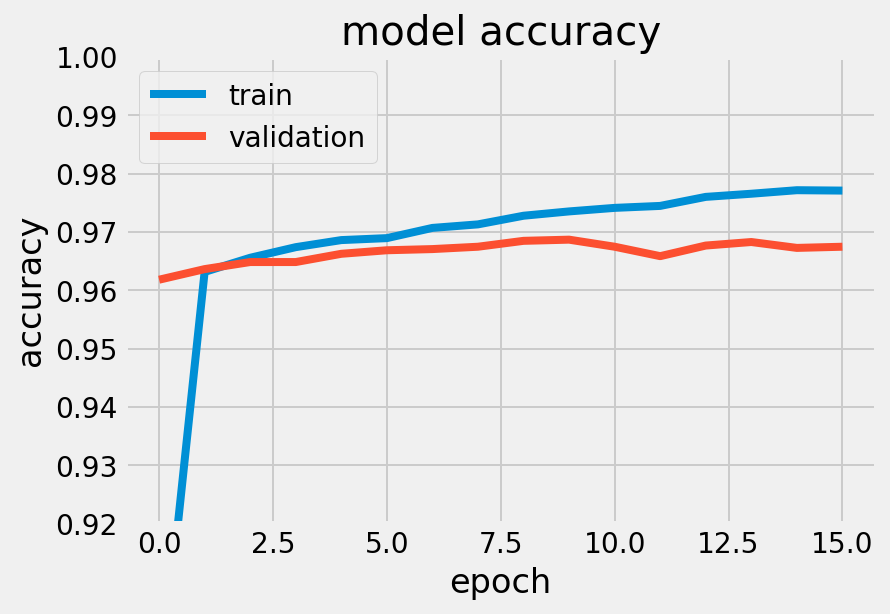

In [33]:
#Results: summarize the history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim(.92,1)
plt.show()


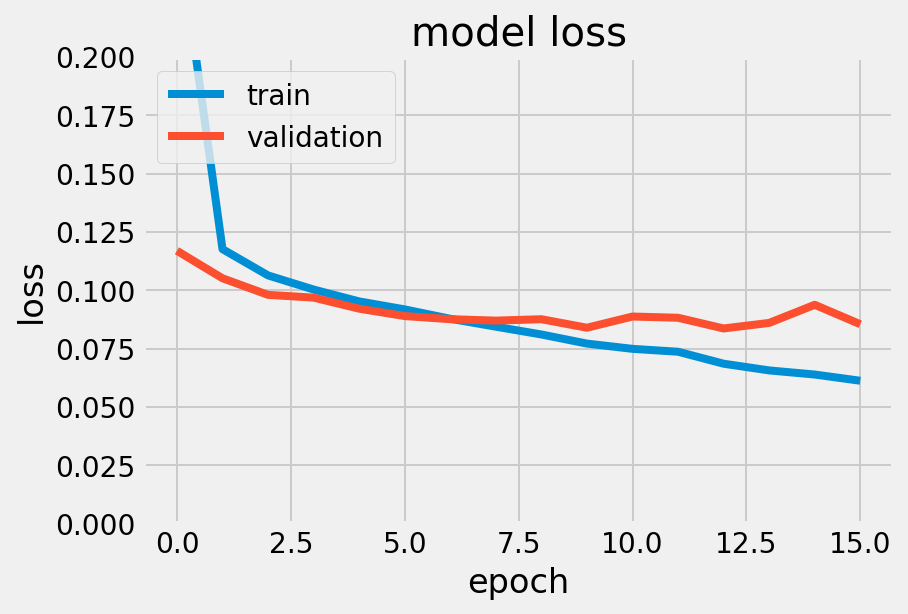

In [34]:
#Summarize for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim((0,.2))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [35]:
#Percentage accuracy of model
print(data_test)
labels_pred = model.predict(data_test)
print(labels_pred)
labels_pred = np.round(labels_pred.flatten())
print(labels_pred)
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))


[[   0    0    0 ...    5    1  516]
 [   0    0    0 ...   26    1   28]
 [   0    0    0 ...    0  193    2]
 ...
 [   0    0    0 ... 1922   12    2]
 [   0    0    0 ...  101 1159   24]
 [   0    0    0 ...   23 7021  192]]
[[9.9998665e-01]
 [9.9999726e-01]
 [9.9961948e-01]
 ...
 [9.9989259e-01]
 [3.5964847e-03]
 [5.7046782e-05]]
[1. 1. 1. ... 1. 0. 0.]
Accuracy: 97.27%


In [36]:
print(labels_test)

[1 1 1 ... 1 0 0]


In [37]:
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')

In [73]:
#s = ["Living with depression and anixety"]
s = ["I am elated"]
# s = ["I am flummoxed"]
#s = ["I am happy because of high scores in semester"]
#s = ["I am fully depressed"]
df = pd.DataFrame(s)
print(df)
depressive_tweets_arr = [x for x in df[0]]
print(depressive_tweets_arr)
t = clean_tweets(depressive_tweets_arr)
print(t)
tweet = tokenizer.texts_to_sequences(t)
print(tweet)
tweet_padd = pad_sequences(tweet, maxlen=MAX_SEQUENCE_LENGTH)
print(tweet_padd.shape)
tweet_pred = model.predict(tweet_padd)
print(tweet_pred)
if(tweet_pred <= 0.5):
    print("Good")
else: print("Bad")

             0
0  I am elated
['I am elated']
['elat']
[[]]
(1, 280)
[[0.5671344]]
Bad


In [39]:
#f1, precision, and recall scores
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1983
           1       0.99      0.96      0.98      2966

    accuracy                           0.97      4949
   macro avg       0.97      0.97      0.97      4949
weighted avg       0.97      0.97      0.97      4949



In [40]:
print('\n# Evaluate')
model.evaluate(data_test, labels_test)


# Evaluate
155/155 [==============================] - 34s 221ms/step - loss: 0.0817 - acc: 0.9727


[0.08172226697206497, 0.9727217555046082]

In [41]:
score = model.evaluate(data_test, labels_test, verbose=0)

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(mean_squared_error(labels_test, labels_pred))
print(r2_score(labels_test, labels_pred))

0.02727823802788442
0.8864054850586016


In [42]:
#https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

#import h5py


#model.save('detector_model_finalX.pt')
#model.save('detector_model_finalX.h5')
'''
save_model(
    model,
    "keras.h5",
    overwrite=True,
    include_optimizer=True
)

json_string = model.to_json()
yaml_string = model.to_yaml()

#convert to json in terminal
#tensorflowjs_converter --input_format keras keras.h5 tensorflowjs/
'''

'\nsave_model(\n    model,\n    "keras.h5",\n    overwrite=True,\n    include_optimizer=True\n)\n\njson_string = model.to_json()\nyaml_string = model.to_yaml()\n\n#convert to json in terminal\n#tensorflowjs_converter --input_format keras keras.h5 tensorflowjs/\n'

In [43]:
#Run the code below to save model to json and serialize the weights to HDF5
'''
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weights.h5")
print("Saved model")
'''

'\nmodel_json = model.to_json()\nwith open("model.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\nmodel.save_weights("model_weights.h5")\nprint("Saved model")\n'

In [44]:
# Run the code below to create pickle
'''
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
'''

"\nimport pickle\n\n# saving\nwith open('tokenizer.pickle', 'wb') as handle:\n    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)\n\n# loading\nwith open('tokenizer.pickle', 'rb') as handle:\n    tokenizer = pickle.load(handle)\n    \n"

# Comparing the Model to Benchmark
In order to evaluate the effectiveness of the LSTM + CNN model, a logistic regression model is trained with the same train data and the same number of epochs, and tested with the same test data.
### Logistic Regression Base Line Model

In [45]:
class LogReg:
    """
    Class to represent a logistic regression model.
    """

    def __init__(self, l_rate, epochs, n_features):
        """
        Create a new model with certain parameters.

        :param l_rate: Initial learning rate for model.
        :param epoch: Number of epochs to train for.
        :param n_features: Number of features.
        """
        self.l_rate = l_rate
        self.epochs = epochs
        self.coef = [0.0] * n_features
        self.bias = 0.0

    def sigmoid(self, score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.

        :param score: A real valued number to convert into a number between 0 and 1
        """
        if abs(score) > threshold:
            score = threshold * sign(score)
        activation = exp(score)
        return activation / (1.0 + activation)

    def predict(self, features):
        """
        Given an example's features and the coefficients, predicts the class.

        :param features: List of real valued features for a single training example.

        :return: Returns the predicted class (either 0 or 1).
        """
        value = sum([features[i]*self.coef[i] for i in range(len(features))]) + self.bias
        return self.sigmoid(value)

    def sg_update(self, features, label):
        """
        Computes the update to the weights based on a predicted example.

        :param features: Features to train on.
        :param label: Corresponding label for features.
        """
        yhat = self.predict(features)
        e = label - yhat
        self.bias = self.bias + self.l_rate * e * yhat * (1-yhat)
        for i in range(len(features)):
            self.coef[i] = self.coef[i] + self.l_rate * e * yhat * (1-yhat) * features[i]
        return

    def train(self, X, y):
        """
        Computes logistic regression coefficients using stochastic gradient descent.

        :param X: Features to train on.
        :param y: Corresponding label for each set of features.

        :return: Returns a list of model weight coefficients where coef[0] is the bias.
        """
        for epoch in range(self.epochs):
            for features, label in zip(X, y):
                self.sg_update(features, label)
        return self.bias, self.coef

In [46]:
def get_accuracy(y_bar, y_pred):
    """
    Computes what percent of the total testing data the model classified correctly.

    :param y_bar: List of ground truth classes for each example.
    :param y_pred: List of model predicted class for each example.

    :return: Returns a real number between 0 and 1 for the model accuracy.
    """
    correct = 0
    for i in range(len(y_bar)):
        if y_bar[i] == y_pred[i]:
            correct += 1
    accuracy = (correct / len(y_bar)) * 100.0
    return accuracy


In [47]:
# Training the logistic regression model
logreg = LogReg(LEARNING_RATE, EPOCHS, len(data_train[0]))
bias_logreg, weights_logreg = logreg.train(data_train, labels_train)
y_logistic = [round(logreg.predict(example)) for example in data_test]

In [48]:
# Getting (and comparing) the accuracy of the logistic regression model predicting the test data
accuracy_logistic = get_accuracy(y_logistic, labels_test)
print('Benchmark Model Accuracy: {:0.3f}'.format(accuracy_logistic))

print("Original Model Accuracy: %.2f%%" % (accuracy*100))

Benchmark Model Accuracy: 58.961
Original Model Accuracy: 97.27%


In [55]:
print(mean_squared_error(labels_test, y_logistic))
print(r2_score(labels_test, y_logistic))

0.41038593655283895
-0.7089663692294825


In [49]:
# creating a RF classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(data_train, labels_train)

# performing predictions on the test dataset
y_pred = clf.predict(data_test)

# metrics are used to find accuracy or error
from sklearn import metrics

# using metrics module for accuracy calculation
#accuracy_RF = metrics.accuracy_score(data_test, y_pred)
#print(accuracy_RF)
#print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(labels_test, labels_pred))
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_pred, labels_test))

ACCURACY OF THE MODEL:  0.9484744392806628


In [56]:
print(mean_squared_error(labels_test, y_pred))
print(r2_score(labels_test, y_pred))

0.05152556071933724
0.7854325828884696


In [57]:
# Keras Sequential model
model = Sequential()
model.add(Dense(12, input_dim=280, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(data_train, labels_train, epochs=10, batch_size=16)
y_predd = model.predict(data_test)
# evaluate the keras model
_, accuracy = model.evaluate(data_test, labels_test)
print('Accuracy: %.2f' % (accuracy*100))
#print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_pred, labels_test))

Epoch 1/10
928/928 [==============================] - 4s 2ms/step - loss: 41.3010 - accuracy: 0.5919
Epoch 2/10
928/928 [==============================] - 2s 2ms/step - loss: 1.8146 - accuracy: 0.5809
Epoch 3/10
928/928 [==============================] - 2s 2ms/step - loss: 0.9269 - accuracy: 0.5925
Epoch 4/10
928/928 [==============================] - 2s 2ms/step - loss: 0.7053 - accuracy: 0.6021
Epoch 5/10
928/928 [==============================] - 2s 2ms/step - loss: 0.6792 - accuracy: 0.6003
Epoch 6/10
928/928 [==============================] - 2s 2ms/step - loss: 0.6461 - accuracy: 0.6066
Epoch 7/10
928/928 [==============================] - 2s 2ms/step - loss: 0.6311 - accuracy: 0.6043
Epoch 8/10
928/928 [==============================] - 2s 2ms/step - loss: 0.6291 - accuracy: 0.6103
Epoch 9/10
928/928 [==============================] - 2s 2ms/step - loss: 0.6507 - accuracy: 0.6144
Epoch 10/10
155/155 [==============================] - 1s 2ms/step - loss: 0.7256 - accuracy: 0.616

In [58]:
print(mean_squared_error(labels_test, y_predd))
print(r2_score(labels_test, y_predd))

0.21267151547670923
0.11437397027866247


In [51]:
# !pip install wordcloud
# !pip install nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
# from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MANASI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [52]:
a = pd.read_csv("vader_processed_final.csv",nrows=20000)
a = a.drop(columns=['Unnamed: 0','Unnamed: 0.1','vader_score'],axis=1)
a = a.rename({'vader_sentiment_label': 'label', 'clean_tweet': 'message'}, axis=1)
filter = a["label"]==0
a.where(filter, inplace = True)
a.dropna(inplace = True)
a['label'] = a['label'].map({0.0:0})
a.shape


2021-11-20 14:00:31,828 : INFO : NumExpr defaulting to 4 threads.


(16337, 2)

In [74]:
b = pd.read_csv("Sentiment Analysis Dataset 2.csv", encoding = "ISO-8859-1",usecols = range(0,4),nrows=33000)
b = b.drop(columns=['ï»¿ItemID','SentimentSource'],axis=1)
b = b.rename({'Sentiment': 'label', 'SentimentText': 'message'}, axis=1)
filter = b["label"]==1
b.where(filter, inplace = True)
b.dropna(inplace = True)
b['label'] = b['label'].map({1.0:1})
b.shape


(16920, 2)

In [75]:
import pandas, sys
import pandas as pd

tweets = pd.merge(a, b, how='outer')
tweets.message=tweets.message.astype(str)
tweets.to_csv('Results.csv', index=False)
# tweets['label'] = tweets['label'].map({0:1 ,1:0}) 
tweets.shape

(33257, 2)

In [76]:
tweets.head(20)

,label,message
0,0,"Wow, dad yday: “you don’t take stupid depressi..."
1,0,part really harmfult lot people went every gui...
2,0,"see wanna one say PTSD, depression, and/or anx..."
3,0,IS IT clinical depression palpable hopelessnes...
4,0,Hope working you. I sertraline year helped dep...
5,0,When depression anxiety strike time I can’t an...
6,0,"I want leave, I'm still waiting legalize Assis..."
7,0,lrt FUCKING DEPRESSION
8,0,If you’re new mother tired postpartum depressi...
9,0,Currently 5:23 I’ve got depression Rangers cou...


In [77]:
trainIndex, testIndex = list(), list()
for i in range(tweets.shape[0]):
    if np.random.uniform(0, 1) < 0.98:
        trainIndex += [i]
    else:
        testIndex += [i]
trainData = tweets.iloc[trainIndex]
testData = tweets.iloc[testIndex]

In [78]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33257 entries, 0 to 33256
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    33257 non-null  int64 
 1   message  33257 non-null  object
dtypes: int64(1), object(1)
memory usage: 779.5+ KB


In [79]:
# pre-process/clean tweets

# remove unwanted characters, remove stop words
# tokenize (split all the sentences in the dataset to get individual words (tokens) 

# Plan to update in the future

# use nltk PorterStemmer() for stemming (for future, consider)

# helper function to clean tweets
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [80]:
class TweetClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.tweets, self.labels = trainData['message'], trainData['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word] + 1) / (self.depressive_words + \
                                                                len(list(self.tf_depressive.keys())))
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word] + 1) / (self.positive_words + \
                                                                len(list(self.tf_positive.keys())))
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 


    def calc_TF_and_IDF(self):
        noOfMessages = self.tweets.shape[0]
        self.depressive_tweets, self.positive_tweets = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_tweets = self.depressive_tweets + self.positive_tweets
        self.depressive_words = 0
        self.positive_words = 0
        self.tf_depressive = dict()
        self.tf_positive = dict()
        self.idf_depressive = dict()
        self.idf_positive = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.tweets.iloc[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels.iloc[i]:
                    self.tf_depressive[word] = self.tf_depressive.get(word, 0) + 1
                    self.depressive_words += 1
                else:
                    self.tf_positive[word] = self.tf_positive.get(word, 0) + 1
                    self.positive_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels.iloc[i]:
                    self.idf_depressive[word] = self.idf_depressive.get(word, 0) + 1
                else:
                    #             idf(t) = log [ n / df(t) ] + 1 (if smooth_idf=False ), 
# where n is the total number of documents in the document set and df(t) is the document frequency of t;
                    self.idf_positive[word] = self.idf_positive.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        self.sum_tf_idf_depressive = 0
        self.sum_tf_idf_positive = 0
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive[word] + self.idf_positive.get(word, 0)))
            self.sum_tf_idf_depressive += self.prob_depressive[word]
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.prob_depressive[word] + 1) / (self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
            
        for word in self.tf_positive:
            # tf-idf(t, d) = tf(t, d) * log(N/(df + 1))
            self.prob_positive[word] = (self.tf_positive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive.get(word, 0) + self.idf_positive[word]))
            self.sum_tf_idf_positive += self.prob_positive[word]
        for word in self.tf_positive:
            self.prob_positive[word] = (self.prob_positive[word] + 1) / (self.sum_tf_idf_positive + len(list(self.prob_positive.keys())))
            
    
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 
                    
    def classify(self, processed_message):
        pDepressive, pPositive = 0, 0
        for word in processed_message:                
            if word in self.prob_depressive:
                pDepressive += log(self.prob_depressive[word])
            else:
                if self.method == 'tf-idf':
                    pDepressive -= log(self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
                else:
                    pDepressive -= log(self.depressive_words + len(list(self.prob_depressive.keys())))
            if word in self.prob_positive:
                pPositive += log(self.prob_positive[word])
            else:
                if self.method == 'tf-idf':
                    pPositive -= log(self.sum_tf_idf_positive + len(list(self.prob_positive.keys()))) 
                else:
                    pPositive -= log(self.positive_words + len(list(self.prob_positive.keys())))
            pDepressive += log(self.prob_depressive_tweet)
            pPositive += log(self.prob_positive_tweet)
        return pDepressive >= pPositive
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

In [81]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels.iloc[i] == 1 and predictions[i] == 1)
        true_neg += int(labels.iloc[i] == 0 and predictions[i] == 0)
        false_pos += int(labels.iloc[i] == 0 and predictions[i] == 1)
        false_neg += int(labels.iloc[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [82]:
sc_tf_idf = TweetClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['message'])
metrics(testData['label'], preds_tf_idf)

Precision:  0.8768472906403941
Recall:  0.9807162534435262
F-score:  0.9258777633289987
Accuracy:  0.9147982062780269


In [83]:
sc_bow = TweetClassifier(trainData, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(testData['message'])
metrics(testData['label'], preds_bow)

Precision:  0.8098434004474273
Recall:  0.9972451790633609
F-score:  0.8938271604938273
Accuracy:  0.8714499252615845
